In [57]:
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import yfinance as yf

In [39]:
API_KEY = os.getenv('POLY_API')

In [70]:
ticker = 'AAPL'
exp_date = '2025-06-06'
option_type = 'call'
numbers = 250 # 10~250

url = f"https://api.polygon.io/v3/snapshot/options/{ticker}?expiration_date={exp_date}&contract_type={option_type}&order=asc&limit={numbers}&sort=ticker&apiKey={API_KEY}"

In [71]:
ticker = yf.Ticker("AAPL")
S0 = ticker.info['regularMarketPrice']
print(f"AAPL current price: ${S0}")

K = []
otm_iv = []
is_next = True

while is_next:
    response = requests.get(url, params={"apiKey": API_KEY})
    response.raise_for_status()

    data = response.json()
    for contract in data.get("results", []):
        if "close" not in contract["day"].keys():
            print(contract)
            continue
        s0 = contract["day"]["close"]
        k = contract["details"]["strike_price"]
        if S0 < k:
            
            if "implied_volatility" in contract.keys():
                K.append(k)
                otm_iv.append(contract["implied_volatility"])
        else:
            continue
    if 'next_url' in data.keys():
        url = data['next_url']
    else:
        is_next = False


AAPL current price: $202.62


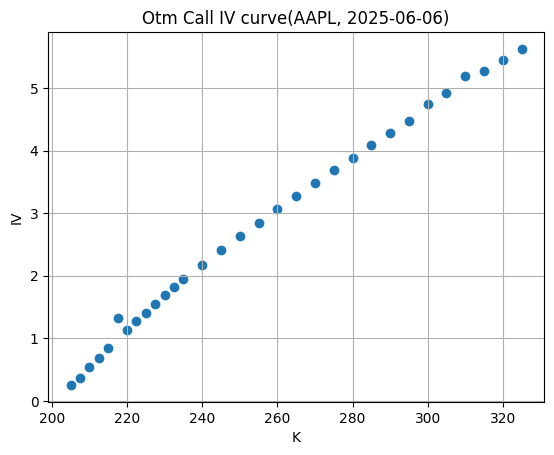

In [72]:
# plt.plot(us, sa_iv_cal.IV_curve(param=[-.04, 0.2, 0.04], lnK=us))
plt.scatter(K, otm_iv)
plt.title("Otm Call IV curve(AAPL, 2025-06-06)")
plt.xlabel("K")
plt.ylabel("IV")
plt.grid()
plt.show()

In [83]:
ticker = yf.Ticker("AAPL")
S0 = ticker.info['regularMarketPrice']
print(f"AAPL current price: ${S0}")

ticker = 'AAPL'
exp_date = '2025-06-06'
numbers = 250 # 10~250
data_all = []
target_dates = ["2025-06-06", "2025-06-13", "2025-06-20", "2025-06-27"]
for date in target_dates:
    temp_list = []
    for type in ["call", "put"]:
        url = f"https://api.polygon.io/v3/snapshot/options/{ticker}?expiration_date={date}&contract_type={type}&order=asc&limit={numbers}&sort=ticker&apiKey={API_KEY}"
        K = []
        lnK = []
        otm_iv = []
        is_next = True

        while is_next:
            response = requests.get(url, params={"apiKey": API_KEY})
            response.raise_for_status()

            data = response.json()
            for contract in data.get("results", []):
                if "close" not in contract["day"].keys():
                    continue

                k = contract["details"]["strike_price"]
                if type == "call":
                    if S0 < k:
                        
                        if "implied_volatility" in contract.keys():
                            K.append(k)
                            lnK.append(np.log(k/S0))
                            otm_iv.append(contract["implied_volatility"])
                    else:
                        continue
                else:
                    if S0 > k:
                        
                        if "implied_volatility" in contract.keys():
                            K.append(k)
                            lnK.append(np.log(k/S0))
                            otm_iv.append(contract["implied_volatility"])
                    else:
                        continue
            if 'next_url' in data.keys():
                url = data['next_url']
            else:
                is_next = False
        temp_list.append({
            "K": K,
            "lnK": lnK,
            "otm_iv": otm_iv
        })
        
    data_all.append({
        "Date": date,
        "Call_IV":temp_list[0],
        "Put_IV": temp_list[1]
    })
    
with open("../data/aapl_options_iv.json", "w") as f:
    json.dump(data_all, f)

AAPL current price: $203.74


In [85]:
len(data_all[0]["Call_IV"]['lnK'])

31